In [3]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import os

Parámetros del sistema

In [4]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 8 # Frecuencia natural x<0
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa
m = 1 # masa del oscilador
N = 100 # Numero de fonones
X_0 = 10 # Condición inicial

In [5]:
dwc = 0.006 # paso en la frecuencia externa
wc =  np.array([i*dwc for i in range(int(0.5/dwc),int(2/dwc)+1)]) # Frecuencia fuerza externa

In [6]:
w =  wc[[i*8 for i in range(32)]] # Frecuencia fuerza externa
n = np.size(w)
print(w)

[0.498 0.546 0.594 0.642 0.69  0.738 0.786 0.834 0.882 0.93  0.978 1.026
 1.074 1.122 1.17  1.218 1.266 1.314 1.362 1.41  1.458 1.506 1.554 1.602
 1.65  1.698 1.746 1.794 1.842 1.89  1.938 1.986]


Frecuencia natural del oscilador

In [7]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [6]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [7]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/np.pi)**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [8]:
x = np.linspace(-25,25,2500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


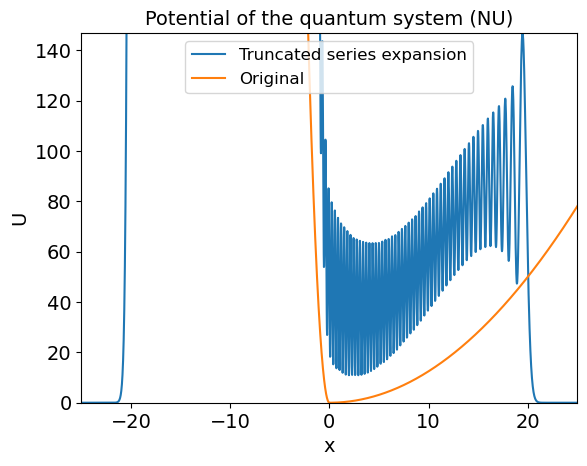

In [9]:
fig1 = plt.figure()
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system (NU)',fontsize = 14)
plt.xlabel('x',fontsize = 14)
plt.ylabel('U',fontsize = 14)
plt.legend(fontsize = 12)
plt.show()

In [10]:
newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [11]:
fig1.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')/Quantum_potential (N = '+str(N)+' phonons).png')

Simulación de la dinámica cuántica

In [8]:
dt = 0.002 # Paso de tiempo
t0 = 0
tf = 800 # Tiempo de medida
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [13]:
lines = ['dt = '+str(dt),'tf = '+str(tf),'w_0 = '+str(w_0),'W_0 = '+str(W_0),'f_0 = '+str(f_0),'N = '+str(N),'X_0 = '+str(X_0),'w = '+str(w)]
with open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')/param.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [14]:
def check_state(psi):
    check = np.sum(psi[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [16]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5)*math.sqrt(w_0*m))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m)
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

In [16]:
def H1coeff(t,args):
    return -f_0*m*np.cos(args['w']*t)

In [17]:
result = []
H0 = w_0*momentum(N)**2/2+U_q
H1 = position(N)/math.sqrt(w_0*m)
options = Options(store_states=True,nsteps=1000000)
for i in tqdm(range(n)):
    args = {'w': w[i]}
    H = [H0,[H1,H1coeff]]
    result.append(mesolve(H, psi0, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options,args=args))

100%|██████████| 32/32 [7:39:26<00:00, 861.45s/it]  


Time series information

In [18]:
O = []
coh = []
indW = np.array([np.searchsorted(tvec,i*0.5) for i in range(tf*2)]) # Calculamos los índices
tW = tvec[indW]

for j in range(n):
    aux = []
    aux2 = []
    for i in tqdm(range(np.size(tW))): 
        psi = result[j].states[int(tW[i]/dt)]
        #check_state(psi)
        alpha = expect(destroy(N),psi)
        
        psi_t = coherent(N,alpha)
        aux.append(abs(psi.overlap(psi0)))
        aux2.append(abs(psi_t.overlap(psi)))
    O.append(aux)
    coh.append(aux2)

100%|██████████| 1600/1600 [00:59<00:00, 26.83it/s]


In [19]:
exp_x = []
exp_p = []
desv_x = []
desv_p = []

for i in range(n):
    exp_x.append(result[i].expect[0])
    exp_p.append(result[i].expect[1])
    desv_x.append(np.sqrt(result[i].expect[2]-result[i].expect[0]*result[i].expect[0]))
    desv_p.append(np.sqrt(result[i].expect[3]-result[i].expect[1]*result[i].expect[1]))

Quantum bifurcation diagram

In [20]:
qbif = np.zeros([np.size(w),np.size(x)])
prob = []

for k in tqdm(range(n)):

    T = 2*math.pi/w[k] # Periodo fuerza externa
    Np = int(tf/T) # Número de puntos que usamos en el promedio
    ind = np.array([np.searchsorted(tvec,T*(i+1)) for i in range(Np-1)]) # Calculamos los índices
    aux = 0

    dop = np.zeros([np.size(ind),np.size(x)])

    for j in range(np.size(ind)):
        fdo = 0
        for i in range(N):
            fdo = fdo + result[k].states[ind[j]].full()[i]*autoest(i,x,True)
        dop[j] = np.abs(fdo)**2
    prob.append(dop)

    for i in range(len(dop)):
        aux = aux + dop[i]
    qbif[k] = aux/(Np-1)

100%|██████████| 32/32 [07:02<00:00, 13.19s/it]


Quantum Poincaré section

In [23]:
Qpoin = []

for j in range(n):
    T = 2*np.pi/w[j]
    Np = int(tf/T) # Número de puntos que usamos en el promedio
    indW2 = np.array([np.searchsorted(tvec,T*(k+1)) for k in range(Np-1)]) # Calculamos los índices
    aux = 0

    for i in tqdm(indW2):
        aux += wigner(result[j].states[i], wig_xvec, wig_pvec)

    qpoin = aux/(Np-1)
    Qpoin.append(qpoin)

100%|██████████| 251/251 [45:39<00:00, 10.91s/it]


Save data and figures

In [24]:
newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\qbif' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\qpoin' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\overlap' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\coh' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\esp' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

"\nnewpath = r'.\\simulation (f_0 = '+str(format(f_0,'.2f'))+')\\Wneg' \nif not os.path.exists(newpath):\n    os.makedirs(newpath)\n"

Guardamos los datos

In [25]:
for i in tqdm(range(np.size(w))):
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\qbif/qbif ω = '+str(format(w[i],'.3f'))+'.txt',qbif[i])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\qpoin/qpoin ω = '+str(format(w[i],'.3f'))+'.txt',Qpoin[i])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\coh/coh ω = '+str(format(w[i],'.3f'))+'.txt',coh[i])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\overlap/overlap ω = '+str(format(w[i],'.3f'))+'.txt',O[i])
    esp = np.column_stack([exp_x[i],exp_p[i],desv_x[i],desv_p[i]])
    np.savetxt('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\esp/esp ω = '+str(format(w[i],'.3f'))+'.txt',esp)

Cargamos los datos

In [10]:
x = np.linspace(-25,25,2500)
wig_xvec = np.linspace(-5,20,120)
wig_pvec = np.linspace(-30,30,120)
indW = np.array([np.searchsorted(tvec,i*0.5) for i in range(tf*2)]) # Calculamos los índices
tW = tvec[indW]
qbif = np.zeros([n,x.size])
qpoin = np.zeros([n,wig_xvec.size,wig_pvec.size])
O = np.zeros([n,tW.size])
coh = np.zeros([n,tW.size])
neg = np.zeros([n,tW.size])
x_exp = np.zeros([n,tvec.size])
p_exp = np.zeros([n,tvec.size])
desv_x = np.zeros([n,tvec.size])
desv_p = np.zeros([n,tvec.size])

for i in range(n):
    a = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\qbif/qbif ω = '+str(format(w[i],'.3f'))+'.txt','r')
    d = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\qpoin/qpoin ω = '+str(format(w[i],'.3f'))+'.txt','r')
    f = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\coh/coh ω = '+str(format(w[i],'.3f'))+'.txt','r')
    g = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\overlap/overlap ω = '+str(format(w[i],'.3f'))+'.txt','r')
    h = open('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\esp/esp ω = '+str(format(w[i],'.3f'))+'.txt','r')
    
    Qbif = a.readlines()
    Qsec = d.readlines()
    Coh = f.readlines()
    Overlap = g.readlines()
    Esp = h.readlines()

    for j in range(len(Qbif)):
        Qbif[j] = float((Qbif[j].split())[0])
    qbif[i] = (Qbif)
    
    for k in range(len(Qsec)):
        for j in range(len(Qsec)):
            qpoin[i][k][j] = float((Qsec[k].split())[j])

    for j in range(len(Coh)):
        Coh[j] = float((Coh[j].split())[0])
    coh[i] = (Coh)
   
    for j in range(len(Overlap)):
        Overlap[j] = float((Overlap[j].split())[0])
    O[i] = (Overlap)

    for j in range(len(Esp)):
        x_exp[i][j] = float((Esp[j].split())[0])
        p_exp[i][j] = float((Esp[j].split())[1])
        desv_x[i][j] = float((Esp[j].split())[2])
        desv_p[i][j] = float((Esp[j].split())[3])

In [24]:
xp = []
vp = []

rep_w = np.searchsorted(wc, w)
for i in rep_w:
    b = open(r'.\Caos clásico\xp/xp ω = '+str(format(wc[i],'.3f'))+'.txt','r')
    c = open(r'.\Caos clásico\vp/vp ω = '+str(format(wc[i],'.3f'))+'.txt','r')
    XP = b.readlines()
    VP = c.readlines()
    for j in range(len(XP)):
        XP[j] = float((XP[j].split())[0])
        VP[j] = float((VP[j].split())[0])
    xp.append(XP)
    vp.append(VP)

b.close()
c.close()

In [25]:
e = open('.\Caos clásico/explyap.txt','r')

explyap = e.readlines()
lyap = np.zeros(wc.size)
disp = np.zeros(wc.size)

for i in rep_w:
    explyap[i] = explyap[i].split()
    lyap[i] = explyap[i][0]
    disp[i] = explyap[i][1]

e.close()

In [13]:
def EDO(t,y,w): # classical eqs.
    x,v = y
    return [v,-W(x)**2*x+f_0*np.cos(w*t)]

In [14]:
def RK4(EDO, x0, y0, xf, h, w):

    # EDO: Array de ecuaciones diferenciales de primer orden
    # x0: valor inicial de la variable independiente
    # y0: valor de la variable dependiente evaluada en x = x0 (condición inicial si x=0)
    # xf: valor final de la variable independiente
    # h: tamaño del paso

    n = int((xf-x0)/h)+1 # Calculamos el número de puntos
    m = 2
    
    x = np.empty(n) # Creamos arrays donde almacenar la solución
    y = np.empty([n,m])
    k1,k2,k3,k4= np.empty(m),np.empty(m),np.empty(m),np.empty(m)

    x[0] = x0 # Aplicamos las condiciones iniciales
    for j in range(m):
        y[0,j] = y0[j]
    
    for i in range(n-1): # Implementamos el método RK4
        x[i] = x0+i*h
        for j in range(m):
            k1[j] = h*EDO(x[i],y[i,:],w)[j]
        for j in range(m):
            k2[j] = h*EDO(x[i]+0.5*h,y[i]+0.5*k1,w)[j]
        for j in range(m):
            k3[j] = h*EDO(x[i]+0.5*h,y[i]+0.5*k2,w)[j]
        for j in range(m):
            k4[j] = h*EDO(x[i]+h,y[i]+k3,w)[j]
        for j in range(m):
            y[i+1,j] = y[i,j]+(1/6)*(k1[j]+2*k2[j]+2*k3[j]+k4[j]);

    x[n-1] = xf
            
    return x,y

In [17]:
pos = []
mom = []

for i in tqdm(range(np.size(w))):

    t,y = RK4(EDO,t0,[x_0,p_0/m],tf,dt,w[i]) # Resolvemos el sistema

    xc = y[:,0]
    vc = y[:,1]
    pos.append(xc)
    mom.append(m*vc)

100%|██████████| 32/32 [10:46<00:00, 20.21s/it]


Guardamos figuras

In [81]:
fou = scipy.fft.fft(O)
nO = np.size(np.abs(O[0]))
freq = np.fft.fftfreq(nO, tW[1]-tW[0])[:nO//2]

for i in range(n):

    newpath = r'.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Results (ω = '+str(format(w[i],'.3f'))+')' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    fig2,ax2 = plt.subplots()
    ax2.plot(tW,O[i])
    ax2.set_xlim([0,tf])
    ax2.set_ylim([0,1])
    ax2.set_title('Overlap integral',fontsize = 14)
    ax2.set_xlabel('t',fontsize = 14)
    ax2.set_ylabel('<Ψ(t)|Ψ(0)>',fontsize = 14)
    plt.close()
    fig2.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Results (ω = '+str(format(w[i],'.3f'))+')/Overlap (ω = '+str(format(w[i],'.3f'))+').png',dpi=250)

    fig3,ax3 = plt.subplots()
    ax3.plot(tW,coh[i])
    ax3.set_xlim([0,tf])
    ax3.set_ylim([0,1])
    ax3.set_title('Does the state remain coherent as it evolves?',fontsize = 14)
    ax3.set_xlabel('t',fontsize = 14)
    ax3.set_ylabel('Coherence', style = 'italic',fontsize = 14)
    plt.close()
    fig3.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Results (ω = '+str(format(w[i],'.3f'))+')/Coherence (ω = '+str(format(w[i],'.3f'))+').png',dpi=250)


    fig4,ax4 = plt.subplots()
    ax4.plot(freq,(2/nO)*np.abs(fou[i][:nO//2]))
    ax4.set_xlim([np.min(freq),np.max(freq)])
    ax4.set_ylim([0,max((2/nO)*np.abs(fou[i][1:]))])
    ax4.set_title('Frequency spectrum',fontsize = 14)
    ax4.set_xlabel('Frequency',fontsize = 14)
    ax4.set_ylabel('Magnitude',fontsize = 14)
    plt.close()
    fig4.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Results (ω = '+str(format(w[i],'.3f'))+')/Frequency spectrum (ω = '+str(format(w[i],'.3f'))+').png',dpi=250)

    fig5,ax5 = plt.subplots()
    ax5.plot(tvec,desv_x[i], label = 'Δx', alpha = 0.8)
    ax5.plot(tvec,desv_p[i], label = 'Δp', alpha = 0.8)
    ax5.plot(tvec,desv_x[i]*desv_p[i], label = 'Δx·Δp', alpha = 0.4)
    ax5.set_xlim([0,tf])
    ax5.set_title('Time-evolution of the standard deviation',fontsize = 14)
    ax5.set_xlabel('t',fontsize = 14)
    ax5.set_ylabel('Standard deviation',fontsize = 14)
    plt.legend(loc='best',fontsize = 12)
    plt.close()
    fig5.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Results (ω = '+str(format(w[i],'.3f'))+')/Standard deviation (ω = '+str(format(w[i],'.3f'))+').png',dpi=250)

    fig6 = plt.figure(figsize=(12,12), constrained_layout=True)

    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.5)
    ax6 = plt.subplot(gs[0, :2], )
    ax7 = plt.subplot(gs[0, 2:])
    ax8 = plt.subplot(gs[1, 2:])

    ax7.plot(pos[i],mom[i],label='Classical values',alpha = 0.7)
    ax7.plot(x_exp[i],p_exp[i],label='Quantum expected values',color = 'red',alpha = 0.7)
    ax7.set_ylim([np.min([p_exp[i]-desv_p[i],mom[i]]),np.max([p_exp[i]+desv_p[i],mom[i]])])
    ax7.set_xlim([np.min([x_exp[i]-desv_x[i],pos[i]]),np.max([x_exp[i]+desv_x[i],pos[i]])])
    ax7.set_title('Quantum vs. classical phase space',fontsize = 14)
    ax7.legend(fontsize = 12)

    ax8.plot(pos[i],tvec,label='Classical positions',alpha = 0.7)
    ax8.plot(x_exp[i],tvec,label='Quantum expected values', color = 'red',alpha = 0.7)
    ax8.fill_betweenx(tvec,x_exp[i]-desv_x[i],x_exp[i]+desv_x[i],alpha = 0.2, color = 'red', label = 'Standard deviation')
    ax8.set_xlim([np.min([x_exp[i]-desv_x[i],pos[i]]),np.max([x_exp[i]+desv_x[i],pos[i]])])
    ax8.set_ylim([0,tf])
    ax8.set_title('Quantum vs. classical position',fontsize = 14)
    ax8.set_ylabel('t',fontsize = 14)
    ax8.set_xlabel('x',fontsize = 14)

    ax6.plot(tvec,mom[i],label='Classical momentum',alpha = 0.7)
    ax6.plot(tvec,p_exp[i],label='Quantum expected values', color = 'red',alpha = 0.7)
    ax6.fill_between(tvec,p_exp[i]-desv_p[i],p_exp[i]+desv_p[i],alpha = 0.2, color = 'red', label = 'Standard deviation')
    ax6.set_ylim([np.min([p_exp[i]-desv_p[i],mom[i]]),np.max([p_exp[i]+desv_p[i],mom[i]])])
    ax6.set_xlim([0,tf])
    ax6.set_title('Quantum vs. classical momentum',fontsize = 14)
    ax6.set_xlabel('t',fontsize = 14)
    ax6.set_ylabel('p',fontsize = 14)
    plt.close()
    fig6.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Results (ω = '+str(format(w[i],'.3f'))+')/Classical_vs_quantum (ω = '+str(format(w[i],'.3f'))+').png',dpi=250)

    fig8,ax8 = plt.subplots()
    wmap = wigner_cmap(qpoin[i])
    nrm = mpl.colors.Normalize(-qpoin[i].max(), qpoin[i].max())
    ax8.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec*math.sqrt(w_0*m), qpoin[i], 100, cmap=cm.RdBu, norm=nrm)
    ax8.set_xlim([np.min(wig_xvec/math.sqrt(w_0*m)),np.max(wig_xvec/math.sqrt(w_0*m))])
    ax8.set_ylim([np.min(wig_pvec*math.sqrt(w_0*m)),np.max(wig_pvec*math.sqrt(w_0*m))])
    ax8.plot(xp[i],vp[i]*m,'.',color='lawngreen',markersize = 1 ,label = 'Classical values')
    ax8.set_title('Quantum Poincare section',fontsize = 14)
    ax8.set_xlabel('x',fontsize = 14)
    ax8.set_ylabel('p',fontsize = 14)
    ax8.legend(fontsize = 12)
    cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu))
    cbar.set_label(label='$<W(x,p,nT)>$',fontsize = 14)
    plt.close()
    fig8.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Results (ω = '+str(format(w[i],'.3f'))+')/Qsec (ω = '+str(format(w[i],'.3f'))+').png',dpi=250, bbox_inches='tight')

C:\Users\rodri\AppData\Local\Temp\ipykernel_24212\1123188281.py:87: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig6.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')\Results (ω = '+str(format(w[i],'.3f'))+')/Classical_vs_quantum (ω = '+str(format(w[i],'.3f'))+').png',dpi=250)


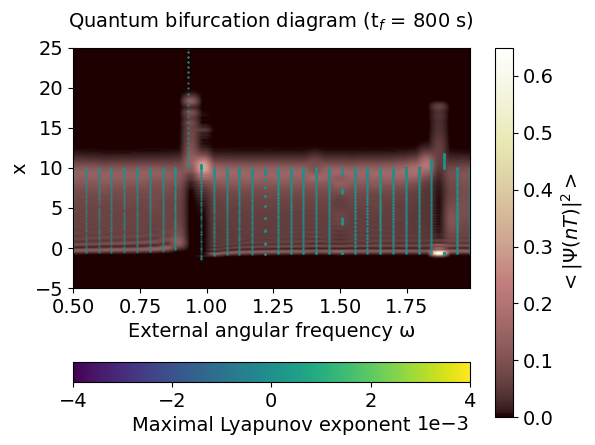

In [82]:
fig9,ax9 = plt.subplots()

nrm2 = mpl.colors.Normalize(0, qbif.max())
norm = colors.Normalize(vmin=-0.004, vmax=0.004)
f2rgb = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('viridis'))

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

im = ax9.imshow(np.flip(np.transpose(qbif),axis = 0),cmap='pink',norm = nrm2, aspect = 'auto', extent = [min(w),max(w),min(x),max(x)])
cbar2 = plt.colorbar(im, pad = 0.05)
cbar2.set_label(label='$<|Ψ(nT)|^2>$',fontsize = 14)

rep_w = np.searchsorted(wc, w)
for i in range(np.size(w)):
        ax9.plot(w[i]*np.ones(np.size(xp[i][:])),np.array(xp[i][:],dtype=object),'.',color=f2rgb.to_rgba(lyap[i])[:3],markersize='1',alpha=0.5)

ax9.set_title('Quantum bifurcation diagram (t$_f$ = '+str(tf)+' s)',fontsize = 14, pad = 15)
ax9.set_ylabel('x',fontsize = 14)
ax9.set_xlabel('External angular frequency ω',fontsize = 14)
plt.ylim([-5,25])

cbar3 = plt.colorbar(f2rgb,orientation="horizontal", pad = 0.20)
cbar3.set_label(label='Maximal Lyapunov exponent',fontsize = 14)
cbar3.formatter.set_powerlimits((0, 0))
'''
axins = ax.inset_axes([0.55, 0.15, 0.4, 0.25])
for i in (rep_w-1):
    axins.plot(wc[i]*np.ones(np.size(xp[i])),np.array(xp[i],dtype=object),'.',color=f2rgb.to_rgba(lyap[i])[:3],markersize='1',alpha=1)
x1, x2, y1, y2 = 0.0, 0.125, -0.1, 0.4
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(colors='white')
#ax.indicate_inset_zoom(axins, edgecolor="black")
'''

fig9.savefig('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')/Qbif ('+str(tf)+').png',dpi=250)
plt.show()

In [83]:
def update_fig(num,qbif,qpoin,xp,vp):
    ax10.cla()
    ax11.cla()

    ax10.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec*math.sqrt(w_0*m), qpoin[num], 100, cmap=cm.RdBu, norm=nrm)
    im = ax11.imshow(np.flip(qbif,axis = 0),cmap='pink',norm = nrm2, aspect = 'auto', extent = [min(x),max(x),min(w),max(w)])
    
    for i in range(np.size(w)):
        ax11.plot(np.array(xp[i][:],dtype=object),w[i]*np.ones(np.size(xp[i][:])),'.',color='lawngreen',markersize='1',alpha=0.5)
    
    ax11.plot([-7,40],[w[num],w[num]], color = 'red')
    ax10.set_xlim([-5,25])
    ax10.set_ylim([-12,12])
    ax10.plot(xp[num],vp[num]*m,'.',color='lawngreen',markersize = 2, label = 'Classical values')
    ax10.set_title('Evolution of the quantum Poincare section with $\omega$',fontsize = 14)
    ax10.set_xlabel('x',fontsize = 14)
    ax10.set_ylabel('p',fontsize = 14)
    ax10.legend(fontsize = 12)
    ax11.set_title('Quantum bifurcation diagram (t$_f$ = '+str(tf)+' s)',fontsize = 14, pad = 15)
    ax11.set_xlabel('x',fontsize = 14)
    ax11.set_ylabel('External angular frequency ω',fontsize = 14)
    ax11.set_xlim([-5,25])
    ax11.invert_yaxis()

    fig10.suptitle('ω = '+str(format(w[num],'.3f')), y = 0.925, fontsize = 14)

C:\Users\rodri\AppData\Local\Temp\ipykernel_24212\486392750.py:16: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')/Qev.gif', dpi=250)
C:\Users\rodri\AppData\Local\Temp\ipykernel_24212\486392750.py:17: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')/Qev.mp4', dpi=250)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


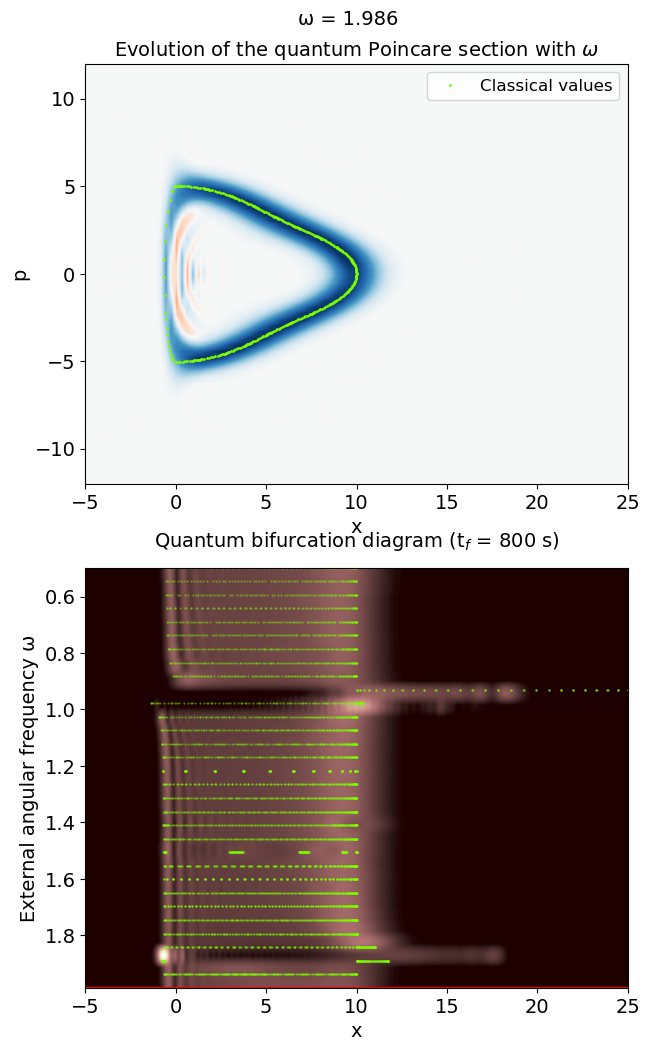

In [84]:
fig10 = plt.figure(figsize = (7,12), constrained_layout=True)

gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0.5)
ax10 = plt.subplot(gs[0, 0])
ax11 = plt.subplot(gs[1, 0])
ax10.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec*math.sqrt(w_0*m), qpoin[0], 100, cmap=cm.RdBu, norm=nrm)
im = ax11.imshow(np.flip(qbif,axis = 0),cmap='pink',norm = nrm2, aspect = 'auto', extent = [min(x),max(x),min(w),max(w)])

for i in range(np.size(w)):
    ax11.plot(np.array(xp[i][:],dtype=object),w[i]*np.ones(np.size(xp[i][:])),'.',color='lawngreen',markersize='1',alpha=0.5)

ax11.plot([-7,40],[w[0],w[0]], color = 'red')

animP = animation.FuncAnimation(fig10, update_fig, np.size(w), fargs = (qbif,qpoin,xp,vp, ), interval = 250)
animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')/Qev.gif', dpi=250)
animP.save('.\simulation (f_0 = '+str(format(f_0,'.2f'))+')/Qev.mp4', dpi=250)